Code from [this](https://hautahi.com/im_greedycelf) blog post. 使用nx重构了代码，原文使用的是igraph库。
# Python Code for Influence Maximization
Kempe et al. （2003） 率先将 IM 正式化为以下组合优化问题：给定一个带有 $n$ 个节点的网络，并给定该网络上的“传播”或传播过程，选择一个大小的 $k<n$ “种子集” $S$，以最大化网络中最终受影响的节点数量。

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time
import networkx as nx

## Diffusion Models
### Independent Cascade Model

IM 算法解决了给定扩展或传播过程的优化问题。因此，我们首先需要指定一个函数来模拟给定种子集在网络上的传播。我们将使用流行的 “Independent Cascade”(IC) 模型来模拟影响力传播，尽管我们还可以选择许多其他模型。描述传播过程的 IC() 函数如下所示。

In [25]:
def IC(g:nx.DiGraph,S,p=0.5,mc=1000):
    """
    :param g: NetworkX graph object
    :param S: Seed nodes
    :param p: Propagation probability
    :param mc: Number of Monte-Carlo simulations
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = [] # 记录每次模拟的传播节点数
    for i in range(mc):
        # Simulate propagation process      
        new_active, A = S[:], S[:] # new_active: 当前轮次新激活的节点，A: 所有激活的节点，S: 种子节点
        while new_active: # 只要还有新节点被激活，继续传播。
            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                # 获取节点的所有出邻居
                neighbors = list(g.successors(node))
                success = np.random.uniform(0, 1, len(neighbors)) < p
                new_ones += list(np.array(neighbors)[success])

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return np.mean(spread)

In [56]:
# 可视化IC函数
def IC_plot(g:nx.DiGraph,S,p=0.5,mc=1000):
    """
    :param g: NetworkX graph object
    :param S: Seed nodes
    :param p: Propagation probability
    :param mc: Number of Monte-Carlo simulations
    """
    
    # Loop over the Monte-Carlo Simulations
    pos = nx.circular_layout(g)  # 节点的布局
    spread = [] # 记录每次模拟的传播节点数
    node_colors = ['r' if i in S else 'grey' for i in g.nodes()]
    spreaded = []
    spreaded.extend(S)
    plt.figure(mc+1, figsize=((mc+1)*5, 5))
    plt.subplot(1, mc+1, 1)
    nx.draw(g, pos, with_labels=True, node_color=node_colors, edge_color='b', font_size=10, node_size=1000, font_color='w', font_weight='bold', width=2.0)
    for i in range(mc):
        # Simulate propagation process      
        new_active, A = S[:], S[:] # new_active: 当前轮次新激活的节点，A: 所有激活的节点，S: 种子节点
        while new_active: # 只要还有新节点被激活，继续传播。
            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                # 获取节点的所有出邻居
                neighbors = list(g.successors(node))
                success = np.random.uniform(0, 1, len(neighbors)) < p
                new_ones += list(np.array(neighbors)[success])

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            spreaded.extend(new_active)
            
        spread.append(len(A))
        node_colors = ['r' if i in spreaded else 'grey' for i in g.nodes()]    
        plt.subplot(1, mc+1, i+2)
        nx.draw(g, pos, with_labels=True, node_color=node_colors, edge_color='b', font_size=10, node_size=1000, font_color='w', font_weight='bold', width=2.0)
    plt.show()
        
    return np.mean(spread)

### Linear Threshold Model

In [84]:
import numpy as np
import networkx as nx

def LT(g:nx.DiGraph, S:list, thresholds:dict, mc:int=1000):
    """
    :param g: NetworkX 图对象
    :param S: 种子节点
    :param thresholds: 节点阈值字典
    :param mc: 蒙特卡洛模拟次数
    """
    
    # 存储每次模拟激活节点的数量
    spread = []
    for i in range(mc):
        # 模拟传播过程      
        new_active, A = S[:], S[:]  # new_active: 当前轮次新激活的节点，A: 所有激活的节点，S: 种子节点
        while new_active:  # 只要还有新节点被激活，继续传播
            new_ones = []  # 存储新激活的节点
            for node in new_active:
                # 对每个新激活节点，检查其邻居
                neighbors = list(g.successors(node))  # 获取出邻居
                for neighbor in neighbors:
                    if neighbor not in A:  # 只考虑未激活的邻居
                        # 计算激活邻居的权重总和
                        active_neighbors = [n for n in g.predecessors(neighbor) if n in A]
                        weight_sum = len(active_neighbors) / len(g.predecessors(neighbor))  # 归一化权重
                        
                        # 检查激活条件是否满足
                        if weight_sum >= thresholds[neighbor]:  # 与阈值比较
                            new_ones.append(neighbor)  # 将满足条件的邻居加入新激活节点

            new_active = list(set(new_ones) - set(A))  # 更新新激活的节点
            A += new_active  # 更新激活节点集合

        spread.append(len(A))  # 记录此次模拟激活节点的数量

    return np.mean(spread)  # 返回所有模拟中激活节点的平均数量


## Greedy Algorithm
有了我们的 spread 函数 `IC()` ，我们现在可以转向 IM 算法本身。我们从开创性的 Kempe et al. （2003） 论文中提出的贪婪算法开始。这基本上是找到散布最大的节点，将其添加到种子集，然后找到在原始散布之上具有下一个最大边际散布的节点，依此类推，直到 k
 找到种子节点。
 
该算法只需要计算节点的$\sum_{i = 0}^k (n - i) = kn$ 次传播过程，其中 $n$ 是网络中的节点数。在我们的 1,000 个节点和 k=5 网络的情况下，它只是 5,000 个（远少于 8 万亿个）传播过程。这使得它成为大型网络的有吸引力的选择。

In [26]:
def greedy(G, k, p=0.1, mc=1000):
    """
    Input:  graph object (networkx), number of seed nodes (k), 
            propagation probability (p), and number of Monte-Carlo simulations (mc)
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time() # S 集合是种子节点集合，spread 是扩散结果，timelapse 是迭代时间
    # 最开始S为空集，我们需要找到一个节点加入S，使得加入这个节点后的扩散结果最大
    # 找出具有最大边际增益的 k 个节点
    for _ in range(k):

        # 在尚未选择的节点中找到具有最大边际增益的节点
        best_spread = 0
        for j in set(G.nodes()) - set(S):

            # 计算该节点的影响力扩散（spread）
            s = IC(G, S + [j], p, mc)

            # 更新当前最优的节点及其对应的扩散值
            if s > best_spread:
                best_spread, node = s, j

        # 将选中的节点加入种子节点集
        S.append(node)
        
        # 记录扩散结果和迭代时间
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return S, spread, timelapse

## Cost Effective Lazy Forward(CELF) Algorithm

CELF 算法由 Leskovec 等人 （2007） 开发。尽管 Greedy 算法比解决完整问题快得多，但在实际大小的网络上使用时，它仍然非常慢。CELF 是最早的重大后续改进之一。

CELF利用了传播函数的次模性属性，这意味着在贪心算法的一次迭代中，给定节点的边际传播量不会比前一次迭代更大。这帮助我们以更复杂的方式选择我们评估传播函数的节点，而不是简单地为所有节点评估传播。更具体地说，在第一轮中，我们像贪心算法一样为所有节点计算传播量，并将它们存储在一个列表中，然后进行排序。自然地，顶部节点在第一次迭代中被添加到种子集中，然后从列表中移除。在下一次迭代中，只计算顶部节点的传播量。如果重新排序后，该节点仍然位于列表顶部，那么它必须具有所有节点中最高的边际增益。为什么？因为我们知道，如果我们为所有其他节点计算边际增益，它们将低于列表中的当前值（由于次模性），因此“顶部节点”将保持在顶部。这个过程继续，找到在计算其边际传播后仍然位于顶部的节点，然后将其添加到种子集中。通过避免为许多节点计算传播量，CELF比贪心算法快得多，我们将在下面展示这一点。

In [27]:

def celf(G, k, p=0.1, mc=1000):
    """
    Input:  graph object (networkx), number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
    
    start_time = time.time()
    
    # 计算初始的边际增益（单节点的影响力）
    marg_gain = [IC(G, [node], p, mc) for node in G.nodes()]

    # 按边际增益从大到小排序，得到候选节点的列表
    Q = sorted(zip(G.nodes(), marg_gain), key=lambda x: x[1], reverse=True)

    # 选择第一个种子节点
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [len(G.nodes())], [time.time() - start_time]

    # 选择剩下的 k-1 个节点
    for _ in range(k-1):    
        check, node_lookup = False, 0
        
        while not check:
            node_lookup += 1
            
            # 获取候选节点
            current = Q[0][0]
            
            # 重新计算该节点加入当前种子集后的边际增益
            Q[0] = (current, IC(G, S + [current], p, mc) - spread)

            # 重新排序
            Q = sorted(Q, key=lambda x: x[1], reverse=True)

            # 检查是否该节点依然是最优的
            check = (Q[0][0] == current)

        # 选择下一个种子节点
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # 移除已选择的节点
        Q = Q[1:]

    return S, SPREAD, timelapse, LOOKUPS

# 一个简单的图例

我们首先测试这些算法，看看它们是否能为我们知道两个最有影响力的节点的简单示例生成正确的解决方案。下面我们创建一个 10 节点/20 边加权和定向的图，并使用 IC() 函数来模拟传播过程。这个人工创建的网络旨在确保节点 0 和 1 最具影响力。为此，我们为每个节点创建 8 个传出链接，而其他 8 个节点最多创建一个链接。我们还确保 0 和 1 不是邻居，这样在种子集中有一个 and 不会使另一个变得多余。绘制网络图可以让我们获得一些关于为什么节点 0 和 1 最有影响力的视觉直觉。

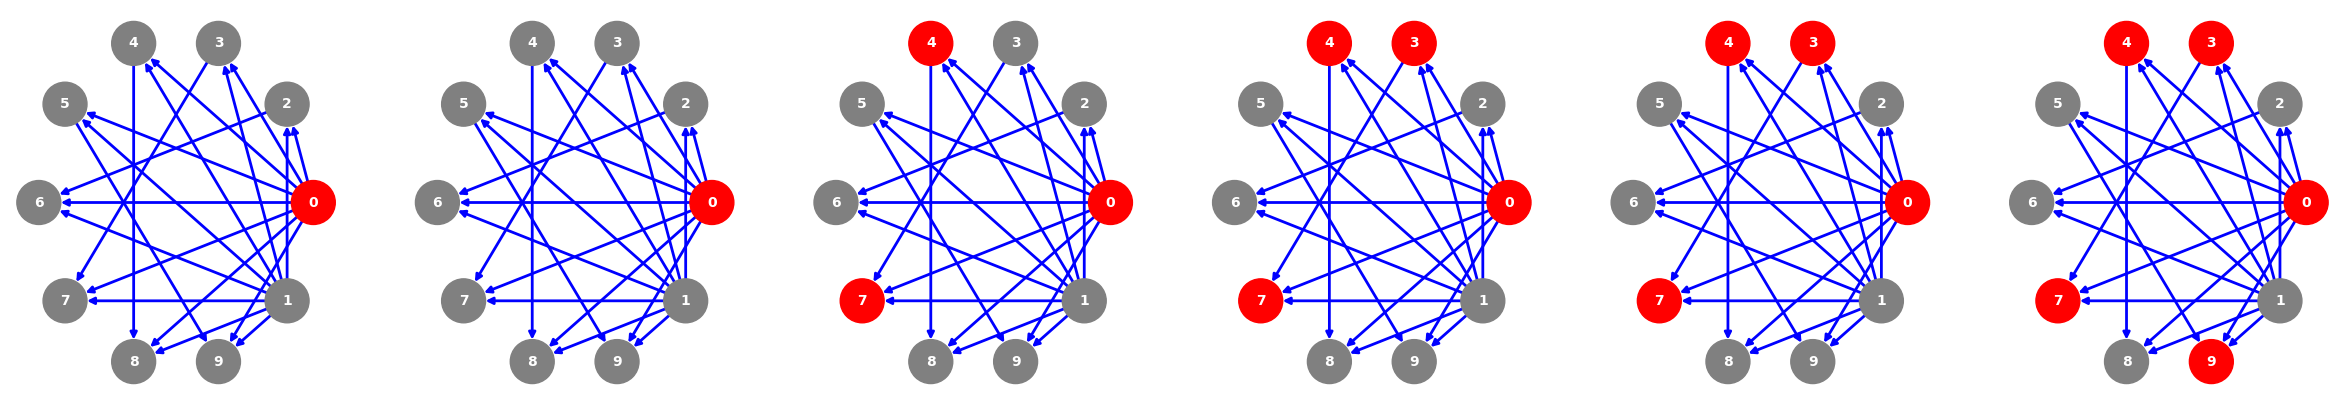

np.float64(1.8)

In [59]:

# Create simple network with 0 and 1 as the influential nodes
source = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]
target = [2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]
g : nx.DiGraph = nx.DiGraph()
g.add_edges_from(zip(source,target))

# Draw the network
# plt.figure()
# pos = nx.circular_layout(g)

# node_colors = ['grey'] * len(g.nodes())
# nx.draw(g, pos, with_labels=True, node_color='gray', edge_color='b', font_size=10, node_size=1000, font_color='k', font_weight='bold', width=2.0)
# plt.show()

IC_plot(g, [0], p=0.1, mc=5)

In [66]:
celf(g, 2, p=0.2, mc=1000)

([0, 1],
 [np.float64(2.874), np.float64(3.874)],
 [0.1219182014465332, 0.30312275886535645],
 [10, 6])

In [67]:
greedy(g, 2, p=0.2, mc=1000)

([0, 1],
 [np.float64(2.874), np.float64(3.874)],
 [0.13501787185668945, 0.4171593189239502])

# 更大的网络
现在我们知道这两个 alorithms 至少对于我们知道答案的简单网络都能正常工作，我们转向一个更通用的图表来比较每种方法的性能和效率

我们将使用 NetworkX 创建一个 1,00 个节点和 300 条边的随机网络。我们将使用 IC() 函数来模拟传播过程，其中传播概率为 0.01。我们将使用 Greedy 和 CELF 算法来找到最具影响力的 5 个节点。我们将使用 1,000 次 Monte-Carlo 模拟来评估每个种子集的影响力。

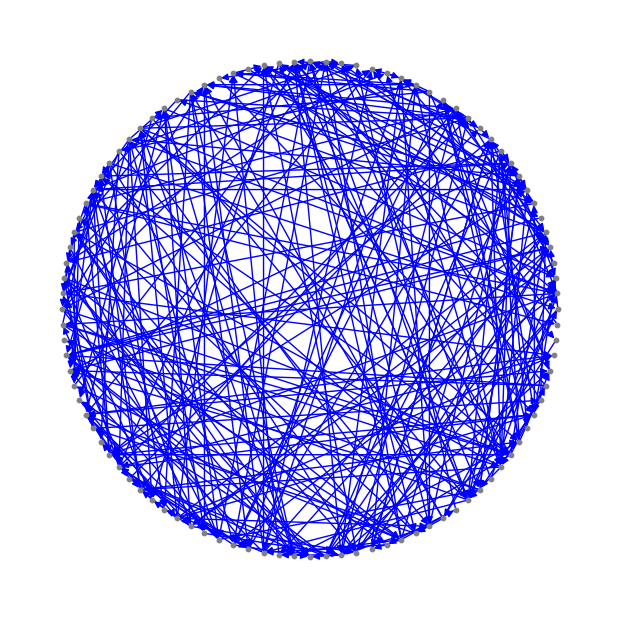

In [80]:
# Create a random network with 100个节点 and 300条边的有向图
seed(0)
n = 100
m = 300
G = nx.gnm_random_graph(n, m, directed=True)
# Draw the network
plt.figure(figsize=(6, 6))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=False, node_color='gray', edge_color='b', node_size=10, font_color='k', font_weight='bold', width=1.0)

现在，我们运行每个算法来求解大小 k=10为的种子集，并选择蒙特 mc=1000 卡洛模拟。（文献中通常使用 10,000 次模拟，但我们在这里选择一个较低的数字，这样我们就不必等待很长时间才能获得结果。

In [81]:
# Run algorithms
celf_output   = celf(G,10,p = 0.1,mc = 1000)
greedy_output = greedy(G,10,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))

celf output:   [90, 11, 81, 19, 17, 33, 58, 66, 40, 38]
greedy output: [90, 11, 81, 19, 17, 33, 58, 66, 40, 38]


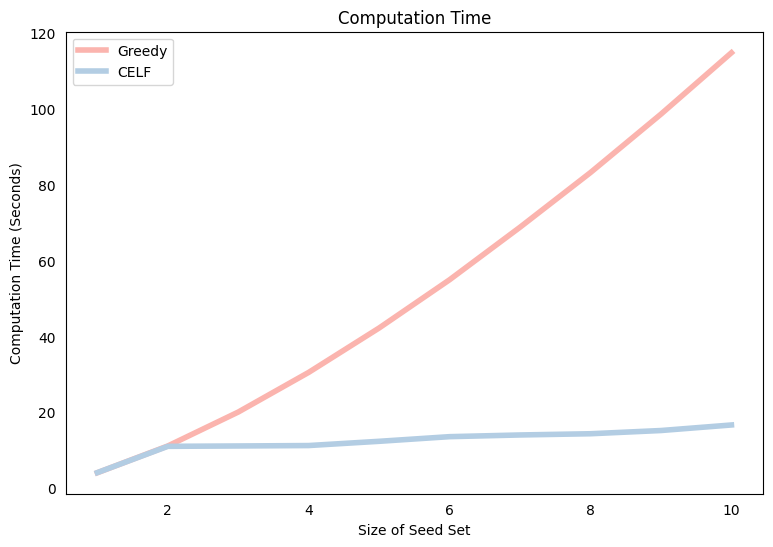

In [83]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output[2])+1),greedy_output[2],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[2])+1),celf_output[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)')
plt.xlabel('Size of Seed Set')
plt.title('Computation Time')
plt.legend(loc=2);

In [ ]:
# 